# Task 3: Customer Churn Prediction (Bank Customers)

## 1. Introduction and Problem Statement

Customer churn occurs when customers stop doing business with a company. For a bank, retaining existing customers is often more cost-effective than acquiring new ones. This project aims to identify bank customers who are likely to leave (churn) by analyzing their profile and transaction history. By predicting churn, the bank can take proactive measures to retain high-risk customers.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 2. Dataset Understanding and Description

The dataset used is the **Churn Modelling Dataset**, which contains information about **10,000 bank customers**. The key features included in the dataset are as follows:

- **CreditScore**: The customer's credit score.
- **Geography**: The country of residence (France, Spain, Germany).
- **Gender**: Male or Female.
- **Age**: The age of the customer.
- **Tenure**: Number of years the customer has been with the bank.
- **Balance**: Account balance.
- **NumOfProducts**: Number of bank products the customer uses.
- **HasCrCard**: Whether the customer has a credit card (1 = Yes, 0 = No).
- **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No).
- **EstimatedSalary**: The customer's annual salary.
- **Exited**: Whether the customer left the bank  
  *(Target Variable: 1 = Yes, 0 = No)*.


In [5]:
import kagglehub
import pandas as pd
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("amisha0528/churn-modelling-dataset")
print("Path to dataset files:", path)

# List files in the directory to find the CSV
files = os.listdir(path)
print("Files in directory:", files)

# Load the dataset (Identify the CSV file)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

# Initial Inspection
print("\nDataset Shape:", df.shape)
df.head()

Path to dataset files: /kaggle/input/churn-modelling-dataset
Files in directory: ['Churn_Modelling.csv']

Dataset Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 3. Data Cleaning and Preparation

In this step, the necessary libraries are imported and the dataset is loaded. Columns that do not contribute to the prediction process (such as customer names and identification numbers) are removed. Additionally, the dataset is checked for missing values to ensure data quality before model building.


In [6]:
# Remove unnecessary columns
# This fixes the NameError because 'df' is now defined above
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Check for missing values
print("Missing Values per column:")
print(df_clean.isnull().sum())

# Display cleaned data info
df_clean.info()

Missing Values per column:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int

## 4. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) helps in understanding the underlying patterns and relationships within the data. In this step, we visualize the distribution of customer churn and analyze how different features, such as **Geography**, are related to the customer exit rate.


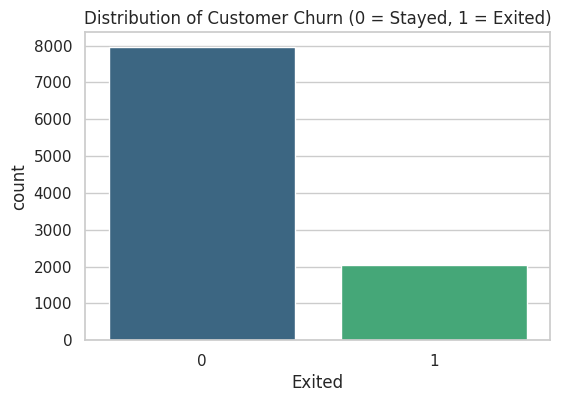

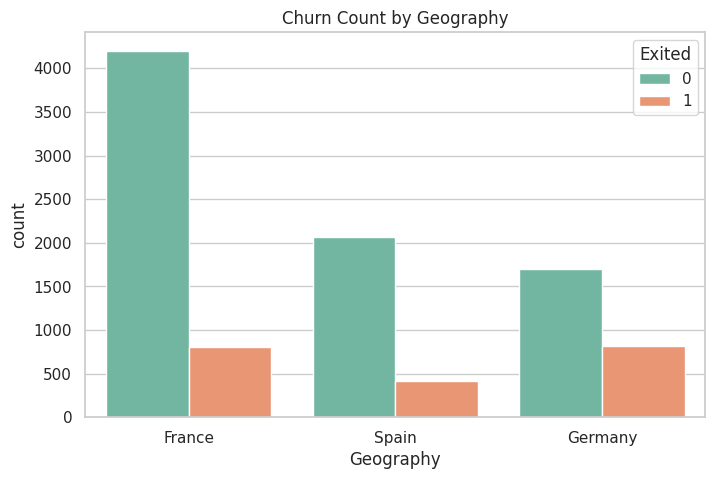

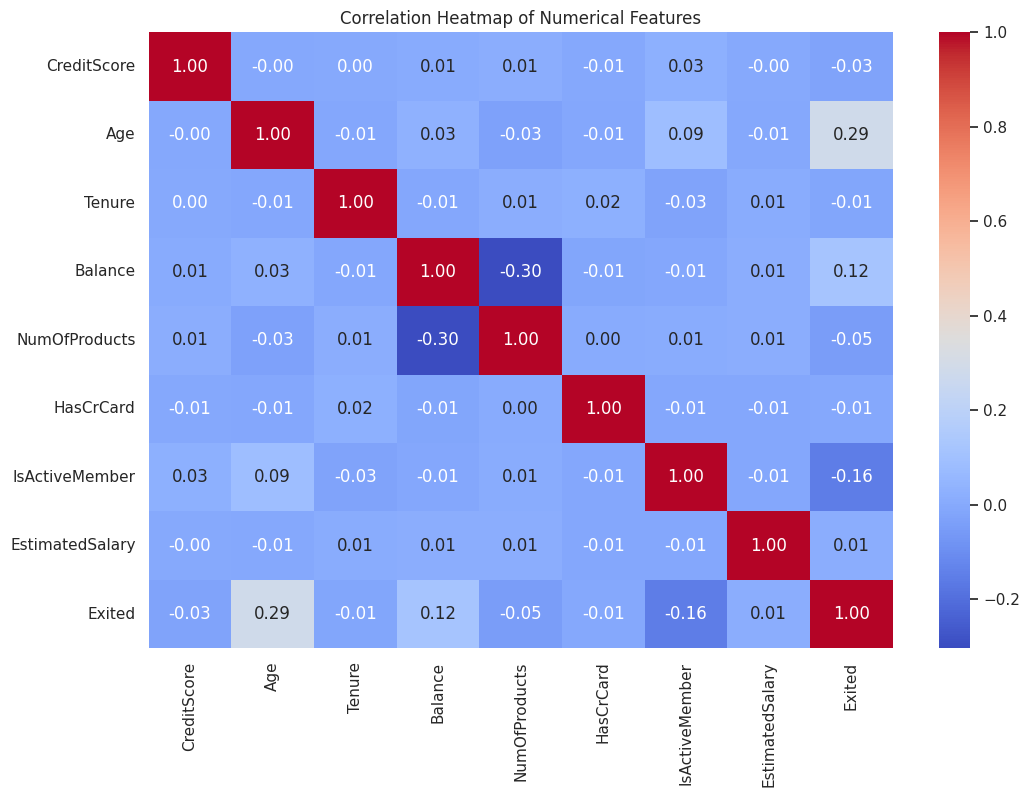

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# 1. Target Distribution (Exited)
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df_clean, hue='Exited', palette='viridis', legend=False)
plt.title('Distribution of Customer Churn (0 = Stayed, 1 = Exited)')
plt.show()

# 2. Churn by Geography
plt.figure(figsize=(8, 5))
sns.countplot(x='Geography', hue='Exited', data=df_clean, palette='Set2')
plt.title('Churn Count by Geography')
plt.show()

# 3. Correlation Heatmap (Numerical features only)
plt.figure(figsize=(12, 8))
numeric_df = df_clean.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## 5. Model Training and Testing

Before training the model, categorical variables such as **Gender** and **Geography** are encoded into numeric values. The dataset is then split into training and testing sets. Finally, a **Random Forest Classifier** is trained using the training data to predict customer churn.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Encoding Categorical Features
le = LabelEncoder()
df_clean['Gender'] = le.fit_transform(df_clean['Gender'])

# One-hot encoding for Geography
df_encoded = pd.get_dummies(df_clean, columns=['Geography'], drop_first=True)

# Define X (Features) and y (Target)
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


## 6. Evaluation Metrics

The performance of the trained model is evaluated using **Accuracy**, the **Confusion Matrix**, and a **Classification Report**. These metrics help assess how well the model predicts both churners and non-churners.


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions
y_pred = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 86.60%

Confusion Matrix:
[[1552   55]
 [ 213  180]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.46      0.57       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



## 7. Feature Importance Analysis

Analyzing feature importance helps in understanding which variables have the greatest influence on the model’s predictions. This insight allows the bank to identify key factors contributing to customer churn and take targeted actions to reduce customer loss.


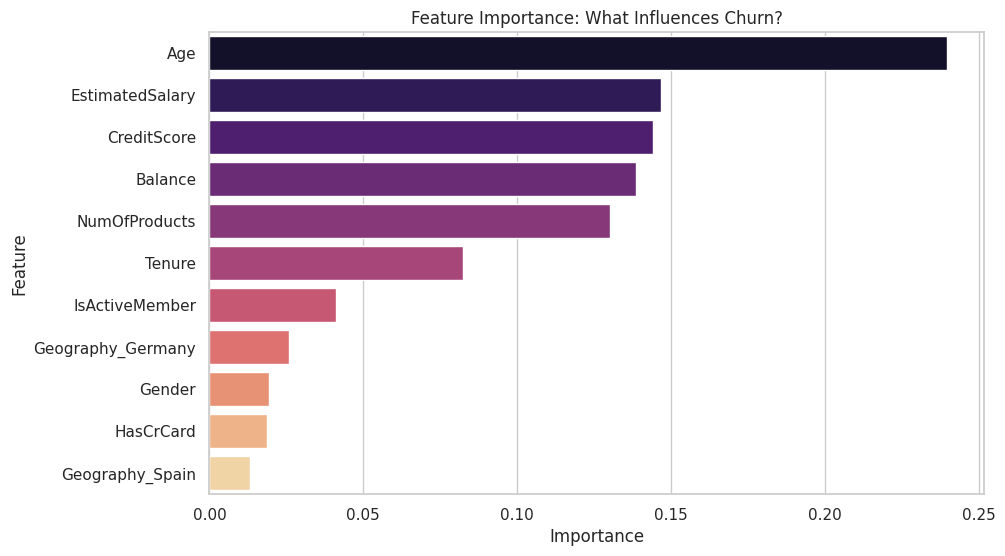

In [11]:
# Extract feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='magma', legend=False)
plt.title('Feature Importance: What Influences Churn?')
plt.show()

## 8. Conclusion

Based on the results of the churn prediction model:

- **Accuracy**: The Random Forest model predicts customer churn with approximately **86.60% accuracy**.
- **Key Factors**: **Age**, **EstimatedSalary**, and **CreditScore** are the most significant drivers of customer churn.
- **Insights**: Younger customers are more likely to remain with the bank, while customers in certain geographical locations (such as **Germany**) exhibit higher churn rates.
- **Business Action**: The bank should implement targeted retention strategies for **older, high-balance customers** who show signs of inactivity.
